# Homework 3.

Salette Guadalupe Noemi Villalobos A01246619

Erick Hernández Silva A01750170

Israel Sánchez Miranda A01378705

Loading imports and necessary libraries.

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from tqdm import tqdm
from sklearn.svm import SVC
from torchvision import transforms
from ucimlrepo import fetch_ucirepo 
from torchvision.models import resnet18
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Letter recognition with ML

### Dataset Overview
The dataset used in this experiment is the Letter Recognition dataset from the UCI Machine Learning Repository. It contains 20,000 instances of character image features, where each instance represents a black-and-white pixel display of one of the 26 capital letters in the English alphabet. The objective is to classify each instance accurately as a particular letter based on 16 primitive numerical attributes. Each letter is represented with slight distortions across 20 different fonts, and the features capture properties like position, size, edge counts, and pixel correlations.

In [3]:
  
# fetch dataset 
letter_recognition = fetch_ucirepo(id=59) 
  
# data (as pandas dataframes) 
X = letter_recognition.data.features 
y = letter_recognition.data.targets 
  
# metadata 
print(letter_recognition.metadata) 
  
# variable information 
print(letter_recognition.variables) 


{'uci_id': 59, 'name': 'Letter Recognition', 'repository_url': 'https://archive.ics.uci.edu/dataset/59/letter+recognition', 'data_url': 'https://archive.ics.uci.edu/static/public/59/data.csv', 'abstract': 'Database of character image features; try to identify the letter', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 20000, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['lettr'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Thu Sep 28 2023', 'dataset_doi': '10.24432/C5ZP40', 'creators': ['David Slate'], 'intro_paper': None, 'additional_info': {'summary': 'The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet.  The character images were based on 20 different fonts and each letter within these 20 fonts wa

### Experimental Setup
**Data Preparation and Encoding**: The dataset was loaded and split into features X and target y. As the target variable (lettr) is categorical (representing letters A-Z), it was encoded to numerical values for compatibility with the machine learning models.

**Data Splitting**: To evaluate model performance, we applied a 70-30 train-test split. This way, 70% of the data was used to train the models, while the remaining 30% served as a hold-out set to evaluate the model’s generalizability after hyperparameter tuning.

**Cross-Validation**: The 10-fold cross-validation (CV) technique was used on the training set to get an unbiased estimate of each model's performance. In 10-fold CV, the training data is divided into 10 subsets, with each subset used once as a validation set, and the remaining 9 subsets used for training. This process helps mitigate overfitting and provides a robust assessment of the model’s performance.

In [7]:
# Assuming 'y' is a DataFrame with a single column, we select that column for dtype check
if y.iloc[:, 0].dtype == 'object' or y.iloc[:, 0].nunique() > 1:
    encoder = LabelEncoder()
    y = encoder.fit_transform(y.iloc[:, 0])
else:
    y = y.iloc[:, 0]


In [8]:
# Split the data into train (70%) and hold-out (30%) sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


The following three machine learning models were selected for this experiment:

* **Random Forest**: A flexible, powerful ensemble method based on decision trees. It was chosen for its robustness and ability to capture complex patterns in the data.
* **Support Vector Machine (SVM)**: Known for high performance in classification tasks, especially with complex decision boundaries.
* **K-Nearest Neighbors (KNN)**: A straightforward yet effective method, chosen to evaluate how a simple distance-based classifier performs with this dataset.

Each model was evaluated with 10-fold cross-validation to obtain an initial performance estimate.

In [9]:
# Define the models to train and evaluate with cross-validation
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Perform 10-fold cross-validation
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    cv_results[model_name] = scores.mean()
    print(f"{model_name} 10-fold CV accuracy: {scores.mean():.4f}")


Random Forest 10-fold CV accuracy: 0.9539
Support Vector Machine 10-fold CV accuracy: 0.9149
K-Nearest Neighbors 10-fold CV accuracy: 0.9419



### Hyperparameter Tuning with GridSearchCV
We used GridSearchCV to find the best hyperparameters for each model. GridSearchCV performs an exhaustive search over a specified parameter grid, allowing us to identify the optimal settings for each model.

The following hyperparameters were tuned for each model:

* **Random Forest**: n_estimators (number of trees) and max_depth (maximum depth of each tree).
* **SVM**: C (regularization parameter) and kernel (type of kernel function).
* **KNN**: n_neighbors (number of neighbors) and weights (weight function).

In [12]:
# Tune hyperparameters with GridSearchCV
# Hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 150],
        "max_depth": [None, 10, 20]
    },
    "Support Vector Machine": {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf']
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance']
    }
}

# Dictionary to store the best models after tuning
best_models = {}

# Tuning each model using GridSearchCV with 10-fold cross-validation
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=10, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validated accuracy for {model_name}: {grid_search.best_score_:.4f}\n")


Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 150}
Best cross-validated accuracy for Random Forest: 0.9554

Tuning hyperparameters for Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 10, 'kernel': 'rbf'}
Best cross-validated accuracy for Support Vector Machine: 0.9574

Tuning hyperparameters for K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validated accuracy for K-Nearest Neighbors: 0.9510



### Evaluation on Hold-Out Set
After identifying the best hyperparameters, each tuned model was evaluated on the hold-out set (30% of the data that was not used in training). This allows us to see how each model generalizes to unseen data.

In [11]:
# Evaluate the best models on the hold-out set
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_holdout)
    accuracy = accuracy_score(y_holdout, y_pred)
    print(f"{model_name} hold-out set accuracy: {accuracy:.4f}")
    print(classification_report(y_holdout, y_pred, target_names=encoder.classes_))


Random Forest hold-out set accuracy: 0.9635
              precision    recall  f1-score   support

           A       0.99      0.98      0.99       237
           B       0.89      0.97      0.93       230
           C       0.96      0.95      0.96       221
           D       0.92      0.98      0.95       242
           E       0.97      0.96      0.96       230
           F       0.96      0.95      0.95       232
           G       0.95      0.94      0.95       232
           H       0.92      0.89      0.91       220
           I       0.97      0.92      0.95       226
           J       0.96      0.96      0.96       224
           K       0.95      0.94      0.94       222
           L       0.99      0.97      0.98       228
           M       0.99      0.98      0.99       238
           N       0.99      0.94      0.97       235
           O       0.97      0.96      0.96       226
           P       0.96      0.97      0.97       241
           Q       0.95      0.97    

We tested three machine learning models—Random Forest, Support Vector Machine (SVM), and K-Nearest Neighbors (KNN)—to classify letters based on image features. SVM achieved the highest accuracy on the hold-out set at 96.73%, closely followed by Random Forest at 96.35% and KNN at 95.48%. Hyperparameter tuning through cross-validation significantly enhanced each model's performance, confirming the importance of optimization. Overall, SVM demonstrated the best accuracy and generalizability, while Random Forest offers a strong alternative with the added benefit of feature interpretability.

## Statistical-based filter selection

Statistical-based filter selection methods are techniques used to select relevant features in a dataset based on their statistical relationships with the target variable. These methods are often employed as a preliminary step in feature selection to reduce dimensionality and improve model interpretability. 

The employed dataset [1] consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood. The number is a codification for the following:

1. Red soil
2. Cotton crop
3. Grey soil
4. Damp grey soil
5. Soil with vegetation stubble
6. Mixture class (all types present)
7. Very damp grey soil

The dataset includes 36 features. Each data line starts with the four spectral values for the top-left pixel, followed by values for the top-middle, then top-right, and so on, reading left-to-right, top-to-bottom. The center pixel’s values are in attributes 17, 18, 19, and 20. It is expected to identify these attributes as the more relevant ones. 


In [ ]:
statlog_landsat_satellite = fetch_ucirepo(id=146) 

X = statlog_landsat_satellite.data.features 
y = statlog_landsat_satellite.data.targets

### One-to-Other t-test p-values

A t-test is a statistical test used to compare the means of two groups and determine whether there is a significant difference between them. It is commonly used when you have small sample sizes and want to test hypotheses about the population means. There are several types, in this specific case we employed an Independent two-sample t-test (Unpaired t-test) which compares the means of two independent groups.

- _Null hypothesis (H0)_: The means of the two groups are equal.
- _Alternative hypothesis (H1)_: The means of the two groups are different.

It is commonly used in feature selection, especially in classification tasks with multiple classes. The idea is to test each feature's ability to distinguish between one specific class and all other classes combined. Features with statistically significant differences may be more informative for distinguishing between classes and can be selected as important.

We first identified the unique classes and set an alpha value of $0.05$. We looped through both the features and classes to test one class (`one_class_data`) to the others (`other_classes_data`) using the `ttest_ind` function from Scipy. We stored the p-values and calculate the mean p-value for each feature across all classes. Later, we sorted the features in ascending order and select the top 5 features with the lowest mean p-values.

In [2]:
import pandas as pd
from scipy.stats import ttest_ind


unique_classes = y['class'].unique()
alpha = 0.05

selected_features = []  

for feature_name in X.columns:
    for target_class in unique_classes:
            
        target_index = y[y['class'] == target_class].index
        other_classes_index = y[y['class'] == 2].index 

        one_class_data = X.loc[target_class, feature_name]
        other_classes_data = X.loc[other_classes_index, feature_name]

        t_stat, p_val = ttest_ind(one_class_data, 
                                    other_classes_data)
            
        selected_features.append((feature_name, 
                                            target_class, 
                                            p_val))

selected_features_t = pd.DataFrame(selected_features, 
                                    columns=['Feature', 'Class', 'p-value'])

mean_p_values = selected_features_t.groupby('Feature')['p-value'].mean().reset_index()
mean_p_values_sorted = mean_p_values.sort_values(by='p-value')

features_ttest = mean_p_values_sorted['Feature'].head(5).tolist()
features_ttest

['Attribute18', 'Attribute22', 'Attribute17', 'Attribute34', 'Attribute30']

The mean p-values of the selected features are presented below. As expected, Attribute 18 has a significantly lower value than the others, even falling below $0.0000025$, which strongly indicates its statistical significance.

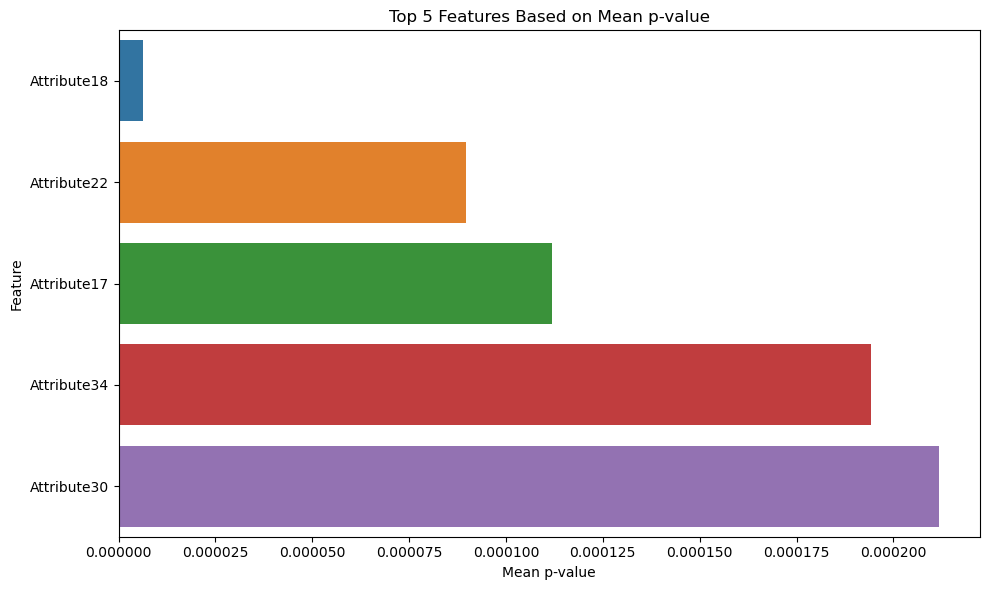

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='p-value', y='Feature', data=mean_p_values_sorted.head(5), hue='Feature')
plt.title('Top 5 Features Based on Mean p-value')
plt.xlabel('Mean p-value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### One-to-Other KS- p-values

A one-to-other Kolmogorov-Smirnov (KS) test is another approach to feature selection, similar to the t-test. The Kolmogorov-Smirnov (KS) test is a non-parametric statistical test used to compare two distributions or to test if a sample comes from a specific distribution. It is based on the largest difference between the cumulative distribution functions (CDFs) of the two distributions. It is  useful when the feature distributions are not normally distributed. The null and alternative hypothesis are: 

- _Null hypothesis (H0)_: The samples come from the same distribution.
- _Alternative hypothesis (H1)_: The samples do not come from the same distribution.

This test compares the cumulative distributions of a feature for one class versus all other classes combined. Low p-values indicate that the feature distribution for the specific class differs significantly from the combined distribution of other classes, making it potentially useful for distinguishing between classes.

We repeated the previous process, this time utilizing the `ks_2samp` function from Scipy.

In [4]:
from scipy.stats import ks_2samp

unique_classes = y['class'].unique()
alpha = 0.05

selected_features = []  

for feature_name in X.columns:
    for target_class in unique_classes:
            
        target_index = y[y['class'] == target_class].index
        other_classes_index = y[y['class'] == 2].index 

        one_class_data = X.loc[target_class, feature_name]
        other_classes_data = X.loc[other_classes_index, feature_name]

        t_stat, p_val = ks_2samp(one_class_data, 
                                    other_classes_data)
            
        if p_val < alpha:
            selected_features.append((feature_name, 
                                            target_class, 
                                            p_val))

selected_features_ks = pd.DataFrame(selected_features, 
                                    columns=['Feature', 'Class', 'p-value'])

mean_p_values = selected_features_ks.groupby('Feature')['p-value'].mean().reset_index()
mean_p_values_sorted = mean_p_values.sort_values(by='p-value')

features_ks= mean_p_values_sorted['Feature'].head(5).tolist()
features_ks

['Attribute18', 'Attribute34', 'Attribute30', 'Attribute17', 'Attribute33']

As before, Attribute 18 has the lowest value of $0.003$.

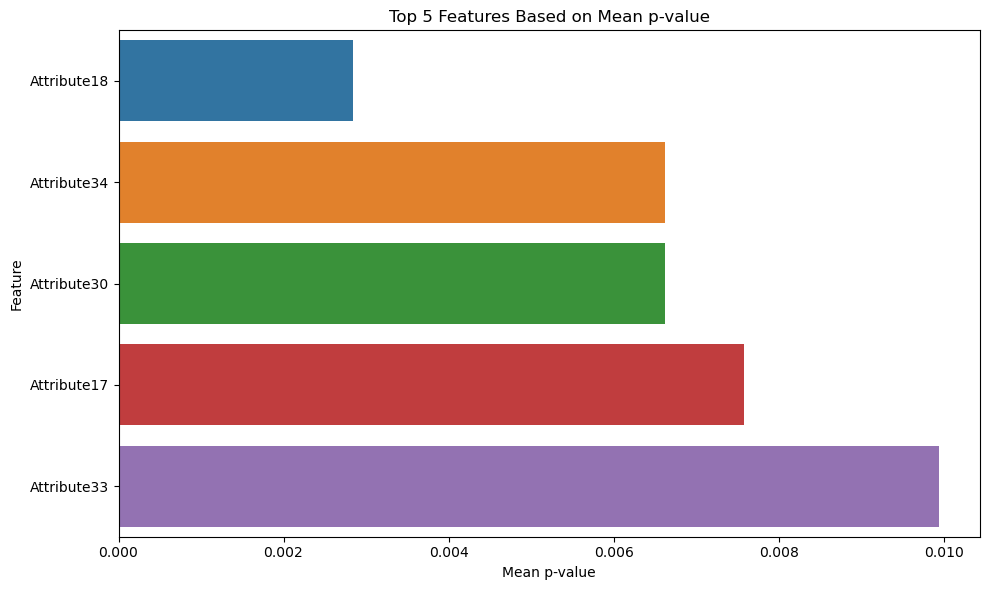

In [5]:
plt.figure(figsize=(10, 6))
sns.barplot(x='p-value', y='Feature', data=mean_p_values_sorted.head(5), hue='Feature')
plt.title('Top 5 Features Based on Mean p-value')
plt.xlabel('Mean p-value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### One-to-Other ROC AUC values

The ROC curve plots the tradeoff between the True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold settings of a classification model.

- True Positive Rate (TPR): the proportion of actual positives that are correctly identified:

$$TPR = \frac{TP}{TP + FN}$$

- False Positive Rate (FPR): the proportion of actual negatives that are incorrectly classified as positives:

$$FPR = \frac{FP}{FP + TN}$$

where 𝐹𝑃 is the number of false positives and 𝑇𝑁 is the number of true negatives.

The AUC measures the area under the ROC curve, providing a value that summarizes the model’s ability to discriminate between the positive and negative classes.

When used for feature selection, ROC AUC can help identify which features are most predictive of the target class, particularly in classification problems. It assesses how well each feature distinguishes one specific class from all other classes, based on the area under the ROC curve.

We trained a simple classifier (Logistic Regression) for each feature. Only employing the selected feature, we predicted the multiclass target, then computed the AUC score by comparing predicted probabilities with the binarized target labels. In this way, we have a AUC score per feature that indicates its ability to classify. Later, we ranked the mean AUC of each feature and selected the top 5 ones. 

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y['class'], classes=list(set(y['class'])))

results = []

for feature in X.columns:

    model = LogisticRegression(solver='liblinear')
    model.fit(X[[feature]], y.values.ravel())
        
    y_probs = model.predict_proba(X[[feature]])

    auc_score = roc_auc_score(y_bin, y_probs, multi_class='ovr')

    results.append({'Feature': feature, 'AUC': auc_score})

AUC_df = pd.DataFrame(results)

mean_auc_values = AUC_df.groupby('Feature')['AUC'].mean().reset_index()
mean_auc_values_sorted = mean_auc_values.sort_values(by='AUC', ascending=False)

features_auc = mean_auc_values_sorted['Feature'].head(5).tolist()
features_auc

['Attribute17', 'Attribute21', 'Attribute13', 'Attribute5', 'Attribute29']

All attributes achieved similar AUC scores, approximately $0.85$, with the highest score being $0.90$ from Attribute17.

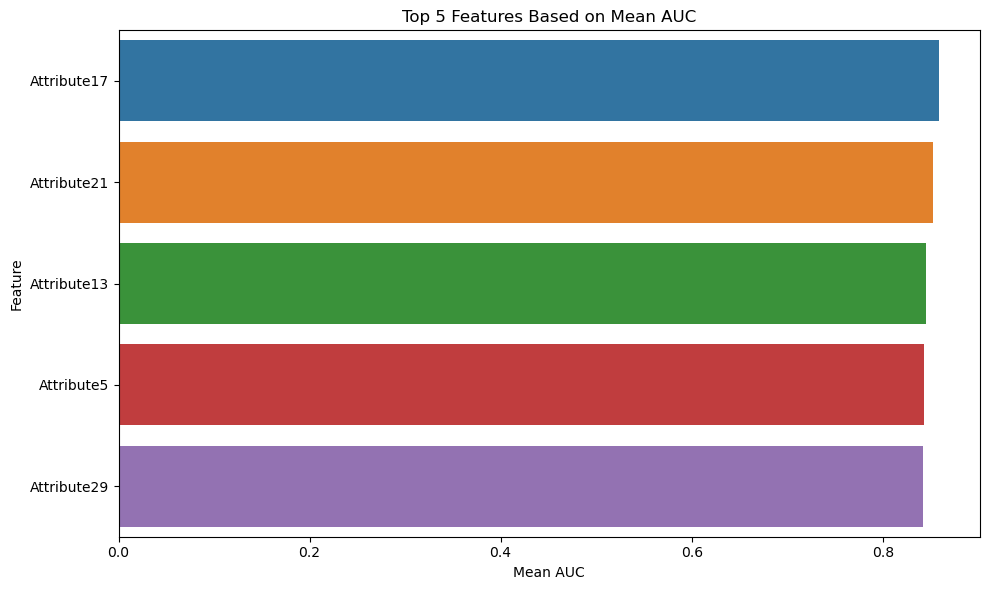

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Feature', data=mean_auc_values_sorted.head(5), hue='Feature')
plt.title('Top 5 Features Based on Mean AUC')
plt.xlabel('Mean AUC')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### False Discovery Rate

False Discovery Rate is a statistical method used to correct for multiple comparisons when performing hypothesis tests, particularly in the context of large-scale testing. FDR helps control the expected proportion of false positives among all the discoveries made during the testing process


Common Methods for FDR Control:

1. Benjamini-Hochberg (BH) Procedure: The most widely used method for controlling FDR. It adjusts p-values so that the expected proportion of false positives among the significant results is controlled at a desired level.

2. Benjamini-Yekutieli (BY) Procedure: A more conservative approach that can be used when tests are dependent (correlated). It controls FDR more strictly.

3. q-value: A concept related to FDR that represents the minimum FDR at which a particular test result is considered significant. It's useful when you have many hypotheses and need to adjust for multiple comparisons.

The Benjamini-Hochberg procedure was applied to the data. Then we selected the ten features with the smallest mean adjusted p-values.

In [8]:
from statsmodels.stats.multitest import multipletests

adjusted_pvals = multipletests(selected_features_t['p-value'], alpha=0.05, method='fdr_bh')[1]
selected_features_t['adjusted p-value'] = adjusted_pvals

mean_p_values = selected_features_t.groupby('Feature')['adjusted p-value'].mean().reset_index()
mean_p_values_sorted = mean_p_values.sort_values(by='adjusted p-value')

features_ttest = mean_p_values_sorted['Feature'].head(5).tolist()
features_ttest

['Attribute18', 'Attribute17', 'Attribute22', 'Attribute34', 'Attribute14']

In [9]:
adjusted_pvals = multipletests(selected_features_ks['p-value'], alpha=0.05, method='fdr_bh')[1]
selected_features_ks['adjusted p-value'] = adjusted_pvals

mean_p_values = selected_features_ks.groupby('Feature')['adjusted p-value'].mean().reset_index()
mean_p_values_sorted = mean_p_values.sort_values(by='adjusted p-value')

features_ks = mean_p_values_sorted['Feature'].head(5).tolist()
features_ks

['Attribute18', 'Attribute17', 'Attribute34', 'Attribute30', 'Attribute33']

### Statistical-based Methods Comparison

To evaluate the performance of the different feature selection methods we trained a Support Vector Classifier (SVC) on the selected subsets of features. The `evaluate_feature_subset` function performs 5-fold cross-validation, returning the mean and standard deviation of the the accuracy and the F1 score (macro-averaged for multiclass data).

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

clf = SVC(kernel='linear', random_state=42)

def evaluate_feature_subset(X, y, features, clf, scoring='accuracy'):
    X_subset = X.loc[:, features]
    scores = cross_val_score(clf, X_subset, y.values.ravel(), cv=5, scoring=scoring)
    return np.mean(scores), np.std(scores)

results = []

for method_name, feature_subset in zip(
    ["T-Test", "KS Test", "ROC AUC"], 
    [features_ttest, features_ks, features_auc]
):

    acc_mean, acc_std = evaluate_feature_subset(X, y, feature_subset, clf, scoring='accuracy')
    results.append({
        'Method': method_name,
        'Metric': 'Accuracy',
        'Mean Score': acc_mean,
        'Std Dev': acc_std
    })
    
    
    f1_mean, f1_std = evaluate_feature_subset(X, y, feature_subset, clf, scoring=make_scorer(f1_score, average='macro'))
    results.append({
        'Method': method_name,
        'Metric': 'F1 Score (Macro)',
        'Mean Score': f1_mean,
        'Std Dev': f1_std
    })

results_df = pd.DataFrame(results)
results_df

,Method,Metric,Mean Score,Std Dev
0,T-Test,Accuracy,0.818182,0.016022
1,T-Test,F1 Score (Macro),0.768462,0.018357
2,KS Test,Accuracy,0.818337,0.018344
3,KS Test,F1 Score (Macro),0.766217,0.017315
4,ROC AUC,Accuracy,0.566278,0.032327
5,ROC AUC,F1 Score (Macro),0.483406,0.018996


The dataframe below shows the selected attributes for each feature selection method. T-Test and KS Test yielded very similar selections, differing by only two attributes, while ROC AUC followed a distinct approach, with only Attribute17 overlapping with the other methods.

In [12]:
rank_comparison = pd.DataFrame({'T-Test': features_ttest,
                                'KS Test': features_ks,
                                'ROC AUC': features_auc})
rank_comparison

,T-Test,KS Test,ROC AUC
0,Attribute18,Attribute18,Attribute17
1,Attribute17,Attribute17,Attribute21
2,Attribute22,Attribute34,Attribute13
3,Attribute34,Attribute30,Attribute5
4,Attribute14,Attribute33,Attribute29


The following plot shows the frequency with which each feature was selected across the three methods. Attribute17 was the only feature chosen by all three methods, while Attribute18 and Attribute34 were each selected twice.

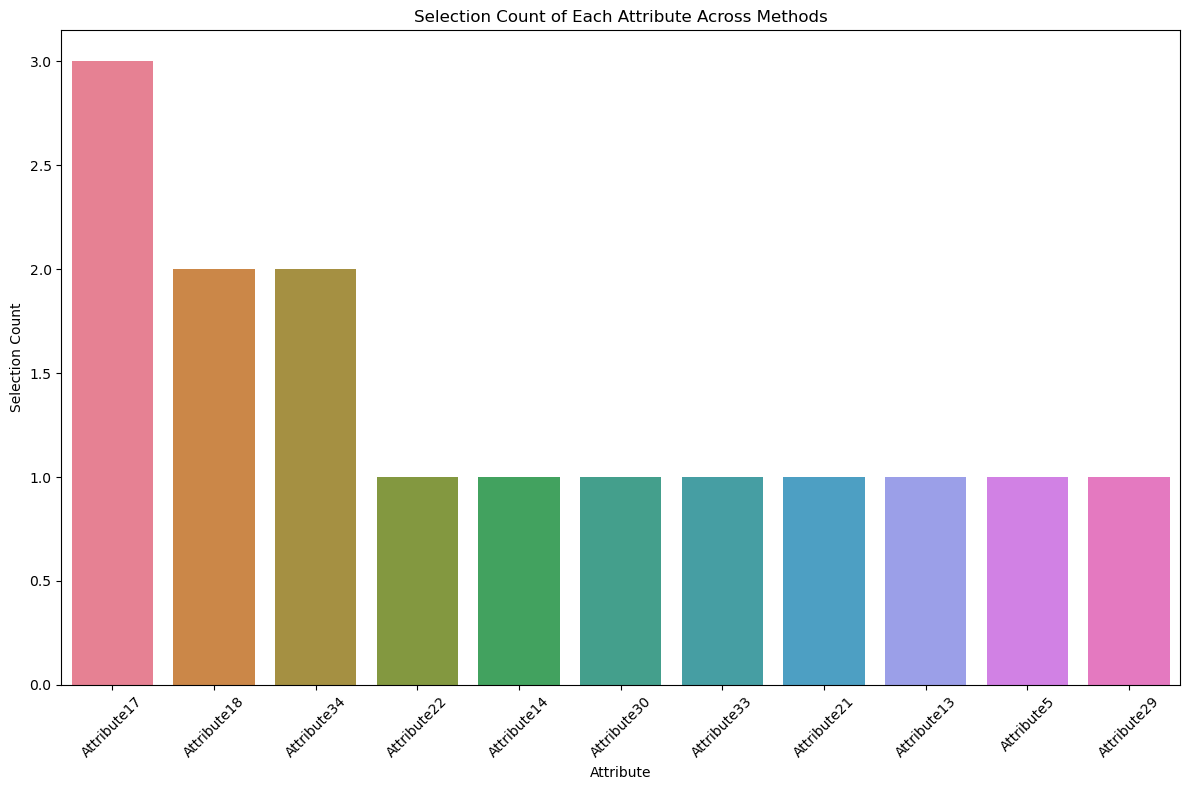

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rank(rank_comparison):
    melted_df = rank_comparison.melt(value_name="Attribute")
    attribute_counts = melted_df['Attribute'].value_counts().reset_index()
    attribute_counts.columns = ['Attribute', 'Selection_Count']

    plt.figure(figsize=(12, 8))
    sns.barplot(data=attribute_counts, x='Attribute', y='Selection_Count', hue='Attribute')

    plt.title('Selection Count of Each Attribute Across Methods')
    plt.xlabel('Attribute')
    plt.ylabel('Selection Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

plot_rank(rank_comparison)

### Heuristic Feature Selection Method

A heuristic feature selection method is an approach that uses rule-based or search-based strategies to find an effective subset of features for a model, rather than relying purely on statistical metrics or exhaustive search. Heuristic methods aim to balance selection quality with computational efficiency, often approximating optimal solutions without guaranteeing them.

In this code, we applied Recursive Feature Elimination (RFE) to select the top 5 features for classification using a linear Support Vector Classifier (SVC). The RFE method was used to iteratively eliminate the least important features based on the model's performance until only 5 features remained. After selecting the features, we evaluated the model’s performance using 5-fold cross-validation with accuracy and macro-averaged F1 score as evaluation metrics. The mean and standard deviation of both scores were calculated. Finally, the selected features were printed, indicating which features were retained (True) or removed (False), along with the mean accuracy and F1 scores after feature selection.


In [14]:
from sklearn.feature_selection import RFE

clf = SVC(kernel='linear', random_state=42) 
selector = RFE(estimator=clf, n_features_to_select=5) 
selector = selector.fit(X, y.values.ravel())

X_selected = selector.transform(X)

scores = cross_val_score(clf, X_selected, y.values.ravel(), cv=5, scoring='accuracy')
acc_mean, acc_std = np.mean(scores), np.std(scores)

scores = cross_val_score(clf, X_selected, y.values.ravel(), cv=5, scoring=make_scorer(f1_score, average='macro'))
f1_mean, f1_std = np.mean(scores), np.std(scores)


print(f"Selected Features (True = selected, False = not selected):\n{selector.support_}")
print(f"Mean Accuracy after feature selection: {acc_mean:.2f}")
print(f"Mean F1 (Macro) after feature selection: {f1_mean:.2f}")

Selected Features (True = selected, False = not selected):
[False False False False False False False False False False False False
 False False False False  True  True False  True False False False False
 False False False False  True  True False False False False False False]
Mean Accuracy after feature selection: 0.84
Mean F1 (Macro) after feature selection: 0.79


### Heuristic vs. Statistical-based Methods

We included the results of the heuristic feature selection method. The best performance was from the heuristic method with an accuracy of $0.84$ and a F1 score of $0.80$. Followed closely by T-Test with $0.81$ and $0.76$. KS Test came next with $0.81$ and $0.76$. And, in last place, with a poor performance was ROC AUC with $0.56$ and $0.48$.

In [15]:
results_df.loc[len(results_df.index)] = ['Heuristic', 'Accuracy', acc_mean, acc_std] 
results_df.loc[len(results_df.index)] = ['Heuristic', 'F1 Score (Macro)', f1_mean, f1_std] 
results_df

,Method,Metric,Mean Score,Std Dev
0,T-Test,Accuracy,0.818182,0.016022
1,T-Test,F1 Score (Macro),0.768462,0.018357
2,KS Test,Accuracy,0.818337,0.018344
3,KS Test,F1 Score (Macro),0.766217,0.017315
4,ROC AUC,Accuracy,0.566278,0.032327
5,ROC AUC,F1 Score (Macro),0.483406,0.018996
6,Heuristic,Accuracy,0.838539,0.017870
7,Heuristic,F1 Score (Macro),0.790710,0.016591


The heuristic method closely approximated the expected feature selection, identifying three of the desired features: Attribute17, Attribute18, and Attribute20.

In [16]:
features_heu = X.loc[:, selector.support_].columns
rank_comparison['Heuristic'] = features_heu
rank_comparison

,T-Test,KS Test,ROC AUC,Heuristic
0,Attribute18,Attribute18,Attribute17,Attribute17
1,Attribute17,Attribute17,Attribute21,Attribute18
2,Attribute22,Attribute34,Attribute13,Attribute20
3,Attribute34,Attribute30,Attribute5,Attribute29
4,Attribute14,Attribute33,Attribute29,Attribute30


Finally, the most frequently selected attribute was Attribute17, which was chosen by all four methods, followed by Attribute18, which was only excluded by one method.

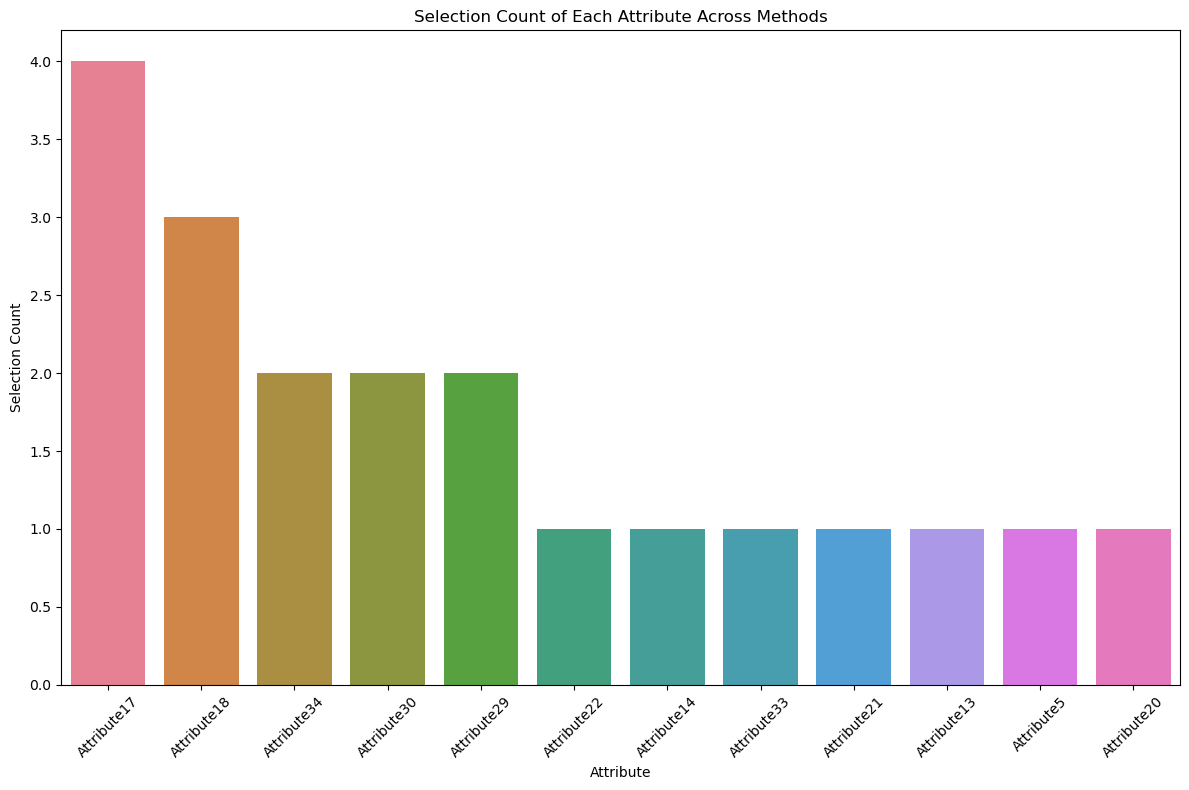

In [17]:
plot_rank(rank_comparison)

### Principal Component Analysis

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a set of correlated variables into a smaller set of uncorrelated variables called principal components. These components are ordered by the amount of variance they explain in the data, with the first component capturing the highest variance, the second component capturing the next highest, and so on. PCA is widely used for reducing the number of features in a dataset, visualizing high-dimensional data, and improving computational efficiency, while maintaining as much of the original variability as possible. PCA is particularly useful when you have a large number of correlated features and want to simplify the dataset without losing significant information.


In this code, we performed PCA for dimensionality reduction. First, X was standardized using `StandardScaler` to ensure all features have a mean of 0 and a standard deviation of 1. Then, PCA was applied to the scaled data to decompose it into principal components. The explained variance ratio of each component was computed, and the cumulative variance was calculated using `np.cumsum` to determine how many components are required to explain at least 95% of the total variance. Finally, a new PCA model was created using six components, and the data was transformed into this reduced-dimensionality space (`X_pca_95`).

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 

print(f"Number of components that explain at least 95% of the variance: {n_components_95}")
print(f"Cumulative explained variance: {cumulative_variance[:n_components_95]}")

pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled)


Number of components that explain at least 95% of the variance: 6
Cumulative explained variance: [0.45354006 0.85236051 0.89615435 0.92085815 0.93917636 0.95609534]


### PCA + LDA

we applied Linear Discriminant Analysis (LDA) for dimensionality reduction and classification. First, the dataset `X_pca_95` (obtained from PCA) was split into training and test sets using `train_test_split`. LDA was then performed on the training data, reducing the dimensionality to 2 components, and the transformed training data (`X_lda`) was used to train the model. After fitting the model, predictions were made on the test set (`X_test`). The model's performance was evaluated using accuracy, confusion matrix, and classification report. 

The results were similar to the previously obtained ones,  showing an accuracy of $0.82$ and macro-average F1 score of $0.78$. When examining the performance per class, all classes exhibited high performance, except for class 4, which had notably lower metrics, even falling below $0.5$.

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_pca_95, y, test_size=0.2, random_state=42)

lda = LinearDiscriminantAnalysis(n_components=2) 
X_lda = lda.fit_transform(X_train, y_train.values.ravel())
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.82
Confusion Matrix:
[[281   0   6   5   3   1]
 [  0 117   0   1  19   0]
 [  1   0 260  19   0   0]
 [  0   0  31  42   2  55]
 [  3   1   0   3  98  34]
 [  0   0  12  27   9 257]]
Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.95      0.97       296
           2       0.99      0.85      0.92       137
           3       0.84      0.93      0.88       280
           4       0.43      0.32      0.37       130
           5       0.75      0.71      0.73       139
           7       0.74      0.84      0.79       305

    accuracy                           0.82      1287
   macro avg       0.79      0.77      0.78      1287
weighted avg       0.82      0.82      0.81      1287



## Digit Recognition using Machine Learning.

In this section we use a Machine Learning (ML) algorithm to recognize the digits of one member of the team. We created a dataset that consists in $10$ images each one is a page with $224$ digits each that go from $0$ to $9$. Then our dataset $D$ is compund of digits $d_i$ such that $d_i\in\{0,1,2,3,4,5,6,7,8,9\}$. All digits are handwritten by one member of the team so the algorithm may be able to recognize the handwritting of such member. 

To train our model on the dataset we need to extract the features of each digit. The features we are going to extract are: 
1. The Hu moments. This features are scale and rotation invariant but can be sensitive to noise in the image.
2. The Euler number. This feature will help to distinguish digit holes. 

### Functions and considerations.

Firstly, we need to define a function to segment the $224$ digits from the source image. For this we define a function `segment_digits` that receives the path of the image and the output size of the segmented digit (by default we define an output image of $28\times28$). We apply a threshold to the image using a binary Otsu algorithm, this due to the simple nature of the image where we have a white background (the page itself) and a black object (the digit). Then we use the `cv2.findCountours` function to detect and isolate the individual handwritten digits in the image. We feed to this function the previously thresholded image and ask the algorithm to return the outer contours (`RETR_EXTERNAL`) to avoid nested contours of each digit. We store the values of each corner using the `cv2.CHAIN_APPROX_SIMPLE` format to speed up the process without losing significant information about the shape.

We then iterate over the contours found and calculate its bounding box using the `cv2.boundingRect` function and extract the digit from the thresholded image. We resize this image to the `output_size` and append it to the array that stores this images along with the coordinates of its bounding box.

In [11]:
def segment_digits(image_path, output_size=(28, 28)):
  """
  Segments digits from a handwritten digit image.

  Parameters:
  - image_path: Path to the image file.
  - output_size: Tuple indicating the size to resize the digit images.

  Returns:
  - A list of tuples (digit_image, bounding_box)
  """

  # Load image in grayscale
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # Threshold the image
  _, thresh = cv2.threshold(img, 255, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  # Find contours of the digits
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  digit_images = []
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    digit = thresh[y:y+h, x:x+w]

    # Resize to standard size
    digit_resized = cv2.resize(digit, output_size, interpolation=cv2.INTER_AREA)
    digit_images.append((digit_resized, (x, y, w, h)))
  return digit_images

Now we define the function `get_features` which extracts the Hu moments and Euler number of a given image. To get the Hu moments the function uses the `cv2.moments` function and then it uses the `cv2.HuMoments` function to finally flatten the result. We make a log scale transformation to reduce the dynamic range of the moments; in this way we improve numerical stability and enchance the discriminative power of the features. 

To calculate the Euler number we threshold the image using the `cv2.THRESH_BINARY` threshold. We then get this number calculating the connected components and substracting the number of holes each digit has (he substract one always to take into account the backgorund that is labeled with `0`).

Finally, we store both the Hu moments and the Euler number in a list.

In [12]:
def get_features(image):
    """
    Calculates Hu moments and Euler number for a given image.

    Parameters:
    - image: The input image.

    Returns:
    - features: A list containing Hu moments and Euler number.
    """

    # Calculate Hu Moments
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Log scale transformation
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)

    # Calculate Euler number
    _, binary_image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)
    euler_number = cv2.connectedComponents(binary_image.astype(np.uint8))[0] - 1

    features = list(hu_moments) + [euler_number]
    return features

Another function is defined; the `prepare_dataset`function takes the images from a folder with the following structure: 
- `folder/`
  - `label_0.jpeg`
  - `label_1.jpeg`
  - `label_2.jpeg`
  - `...`
  - `label_n.jpeg

  The function gets the label for each image and then applies the `segment_digits` to extract the digits of each image. Then, for each digit it gets the Hu moments and Euler number using the `get_features` function to finally store all these information into a dataframe.

In [13]:
def prepare_dataset(image_folder):
    """
    Prepares the dataset from images in a folder.

    Parameters:
    - image_folder: Folder containing images (one image per class, class name must be the name of the image).

    Returns:
    - DataFrame containing features and labels.
    """

    data = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            digit_label = os.path.splitext(filename)[0]
            image_path = os.path.join(image_folder, filename)

            digit_images = segment_digits(image_path)
            for digit_image, _ in digit_images:
                features = get_features(digit_image)
                data.append(features)
                labels.append(digit_label)

    columns = [f'Hu{i+1}' for i in range(7)] + ['EulerNumber']
    df = pd.DataFrame(data, columns=columns)
    df['Digit'] = labels
    return df

In [ ]:
In this experiment, we tested three machine learning models—Random Forest, Support Vector Machine (SVM), and K-Nearest Neighbors (KNN)—to classify letters based on image features. SVM achieved the highest accuracy on the hold-out set at 96.73%, closely followed by Random Forest at 96.35% and KNN at 95.48%. Hyperparameter tuning through cross-validation significantly enhanced each model's performance, confirming the importance of optimization. Overall, SVM demonstrated the best accuracy and generalizability, making it the most suitable model for deployment, while Random Forest offers a strong alternative with the added benefit of feature interpretability.

We used a $k$-Nearest Neighbors ($k$ NN) algorithm to recognize the digits. We define as default $k=3$. In this function we use the `Digit` column as the target value and use the `KNeighborsClassifier` class from `sklearn` for the $k$ NN algorithm. We used a $k$-Fold cross-validation with $10$ folds using a shuffle in our dataset to better train the model and have a more general overview of how it performs. We print the cross-validation scores and the mean score for each fold. 

In [14]:
def train_knn_model(df, k=3):
    """
    Trains a k-NN classifier using 10-fold cross-validation.

    Parameters:
    - df: DataFrame containing features and labels.
    - k: Number of neighbors for k-NN.

    Returns:
    - Trained k-NN model.
    - Cross-validation scores.
    """

    X = df.drop('Digit', axis=1)
    y = df['Digit']

    knn = KNeighborsClassifier(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(knn, X, y, cv=kf)

    knn.fit(X, y)
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean CV score: {cv_scores.mean()}')
    return knn, cv_scores

To test our ML algorithm we use the `classify_id_image` function. This function receives the path to an image which is the one containing the ID of a student written by the same member of the team that wrote the digits originally in order for the ML algorithm to recognize them. It firstly segments each digit found on the image using the `segment_digits`function and then for each digit found it gets its features. The function then organizes each feature in a dataframe and makes a prediction with the mdoel using the `predict` function of the $k$ NN model. Finally we sort the predicted digits based on their $x$ coordinate to mantain order, finally, the function returns the digit predictions. 

In [15]:
def classify_id_image(image_path, knn_model):
    """
    Classifies digits from an image containing the student ID.

    Parameters:
    - image_path: Path to the student ID image.
    - knn_model: Trained k-NN model.

    Returns:
    - List of predicted digits in order.
    """

    digit_images = segment_digits(image_path)

    digit_positions = []
    digit_features = []
    for digit_image, bbox in digit_images:
        features = get_features(digit_image)
        digit_features.append(features)
        digit_positions.append(bbox)

    # Predict digits
    X_new = pd.DataFrame(digit_features, columns=[f'Hu{i+1}' for i in range(7)] + ['EulerNumber'])
    predicted_digits = knn_model.predict(X_new)
    
    # Sort digits based on x-coordinate to maintain order
    digits_with_positions = list(zip(predicted_digits, digit_positions))
    digits_with_positions.sort(key=lambda x: x[1][0])  # Sort by x-coordinate
    ordered_digits = [digit for digit, _ in digits_with_positions]
    return ordered_digits


Another way we calculate the performance of the model is using the Levenshtein distance. This is, calculate how many deletions, insertions and substitutions we need to apply over a string $s_j$ to match an initial string $s_i$. This helps us to appreciate how similar is the predicted ID by the model with the original one.

In [16]:
def levenshtein_distance(s1, s2):
    """
    Calculates the Levenshtein distance between two strings.
    """
    
    if len(s1) < len(s2):
      return levenshtein_distance(s2, s1)
    
    # Initialize previous row of distances
    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            # Cost of deletions, insertions, and substitutions
            deletions = previous_row[j + 1] + 1
            insertions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(deletions, insertions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

### Testing the algorihtm.

We tested the algorithm using thedataset defined at the [start of the section](#digit-recognition-using-machine-learning) using the `prepare_dataset` function over a folder with the structure defined at [Functions and considerations](#functions-and-considerations).

In [17]:
# Prepare the dataset
dataset_folder = 'digits'
df = prepare_dataset(dataset_folder)
print('Dataset prepared.')
df

Dataset prepared.


,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7,EulerNumber,Digit
0,3.139321,7.866246,9.607722,9.994978,-10.0,-9.999999,-10.0,1,0
1,2.470154,5.771757,9.556362,9.572124,10.0,-9.999607,-10.0,1,0
2,2.531530,6.019593,9.456941,9.087261,10.0,9.996963,10.0,1,0
3,2.438113,5.863366,9.253229,9.288303,10.0,9.998040,10.0,1,0
4,2.492358,5.891919,9.609553,9.323692,-10.0,9.998321,10.0,1,0
...,...,...,...,...,...,...,...,...,...
2669,2.680575,6.608726,8.188343,9.077046,-10.0,-9.998576,10.0,1,9
2670,2.618261,6.389477,7.991319,8.819356,10.0,-9.998544,10.0,1,9
2671,2.733390,7.603683,8.433619,9.446449,-10.0,9.999985,10.0,1,9
2672,2.676523,6.789756,8.161121,8.907812,10.0,-9.999589,10.0,1,9


We train our $k$ NN model using $k=2$. The model has a score of approximately $0.5$ which is not the best (basically a coin flip) but for educational purposes it works fine.

In [18]:
# Train the k-NN model
k = 2
knn_model, _ = train_knn_model(df, k=k)
print('k-NN model trained.')

Cross-validation scores: [0.57462687 0.55223881 0.45522388 0.54477612 0.52059925 0.4906367
 0.50187266 0.52434457 0.59550562 0.53558052]
Mean CV score: 0.5295404997484487
k-NN model trained.


We then read the ID handwritten image to test the algorithm.

In [19]:
# Classify digits from the student ID image
id_image_path = 'test.jpeg'
predicted_id = classify_id_image(id_image_path, knn_model)
print(f'Predicted Student ID: {"".join(map(str, predicted_id))}, Real ID is 1378705')

Predicted Student ID: 1378730, Real ID is 1378705


As we can see the algorithm works fairly fine on predicting and extracting the ID from the image. We apply the Levenshtein distance function to see how different are both strings. We also apply a normalized error rate to have a better overview of the proportion of the error.

In [20]:
# Calculate Levenshtein distance
predicted_id_str = "".join(map(str, predicted_id))
actual_id_str = '1378705'
error = levenshtein_distance(predicted_id_str, actual_id_str)
print(f'Levenshtein Distance (Error): {error}')

# Normalize Error Rate
max_length = max(len(predicted_id_str), len(actual_id_str))
error_rate = error / max_length
print(f'Normalized Error Rate: {error_rate:.2f}')

Levenshtein Distance (Error): 2
Normalized Error Rate: 0.29


The Levenshtein distance is of $2$, which means that at least two deletions, insertions or substitutions need to be applied for the predicted ID to be the same as the original ID. In this case we need two substitutions,change $s_6=3$ to $s_6=0$ and $s_7=0$ to $s_7=5$. The same way, we have an error rate of $0.29$ which suggest that almost a $30\%$ of the predicted ID is wrong. A way we can improve this algorithm is to do an exploratory search of the $k$ NN hyper parameters (number of neighbors and similar configurations) to achieve an optimal solution. We can also use different threshold values when doing the digit segmentation to avoid extracting digits incorrectly and confuse the model with this input images. Finally, another thing we can do to improve the algorithm is to increase the number of digit samples to have a bigger dataset. For this we would also try to balance more each digit class because in some cases a digit can be written in more than one way. This was not taken into account when handwritting the dataset and may have result in an inter-class imbalance and thus, impacting greatly on the model performance.

## Digit Recognition using Deep Learning.

It is also possible to do digit recognition using Deep Learning models. In this section we use a ResNet CNN and train it over the same dataset as [past section](#digit-recognition-using-machine-learning) to predict a student ID.

First we make a custom class `DigitDataset` that extends the `torch.utils.data.Dataset` class from PyTorch. This makes a custom dataset class to ease the compatibility between the data and the model. When we `__init__` the class we define an image directory and iterate over it to extract the labels and digits of an image using the `segment_digits()` function defined before. After that we append all this information to the `data` array.

We redefine the `__getitem__` method to obtain the image from the `data` array, we convert the image to RGB format since we are treating with binary images and then return the image and its label.

In [21]:
class DigitDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = []
        self.labels = []

        # Load data and labels
        for filename in os.listdir(image_dir):
            if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
                label = int(os.path.splitext(filename)[0])
                image_path = os.path.join(image_dir, filename)
                digit_images = segment_digits(image_path)  # Assuming this function segments and returns (image, label)
                
                for digit_image, _ in digit_images:
                    self.data.append(digit_image)
                    self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        
        # Ensure the image has 3 channels for ResNet (H, W) -> (H, W, 3)
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB

        image = Image.fromarray(image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

We define a `transforms` object to ensure each digit image has the correct dimensions (28x28 pixels), converting each image to a tensor and normalize it to a range the model will be trained on and to help the model recognize digits even with minor variations in digit position or orientation.

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Now, we define the function `create_resnet_model` function to create a ResNet18 CNN with 10 classes as default (for digits $0$ to $9$) and add a final linear layer for classification.

In [23]:
def create_resnet_model(num_classes=10):
    model = resnet18(pretrained=True)  # Load ResNet18 with pretrained weights
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify the final layer
    return model

We now prepare both the model and the dataset, we define our dataset with its data folder and the transform object. Then we define a `DataLoader` object that will load the data into the model with a batch size of $32$ and `shuffle=True` to better generalize the training. Then, we use the `create_resnet_model`function to define our model; we also define the loss criterion (in this case the cross entropy loss) and an optimizer (Adam optimizer) with a learning rate of $0.001$. We will train this model for $10$ epochs.

In [24]:
# Parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Dataset and DataLoader
train_dataset = DigitDataset('digits', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = create_resnet_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\Israel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Israel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Israel/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.6MB/s]


Sometimes training is too hard for a single CPU to handle, thus, if available, it is recommended to use a GPU (`cuda`) device to train the model. The line `model.to(device)` helps us to load the model into the device we will train it on.

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we define a `train` function, we make a loop for the number of epochs, set the model into training mode and initialize the total loss. We train the model in batches of size $32$. First we get the inputs and its corresponding labels from the batch of the dataloader and move them to the same device we are training the model on. We make a zero-gradient forward pass of the model and compute the loss function of the outputs and its true labels. Then we make a backward pass and update the weights of the model using this criterion. Finally, we track the total loss for each epoch to obtain the average loss of the epoch. 

In [ ]:
# Define the training function
def train(model, dataloader, optimizer, criterion, device, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        total_loss = 0

        # Wrap the dataloader in tqdm for a progress bar
        for batch in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}", unit="batch"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Clear gradients
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            total_loss += loss.item()  # Track total loss for epoch

        avg_loss = total_loss / len(dataloader)
        print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")
        
    print("Training complete.")

Now we train the model using the functions and parameters defined before.

In [30]:
train(model, train_loader, optimizer, criterion, device, 10)

Epoch 1/10


Training Epoch 1: 100%|██████████| 84/84 [08:08<00:00,  5.81s/batch]


Average Loss for Epoch 1: 0.4044
Epoch 2/10


Training Epoch 2: 100%|██████████| 84/84 [08:19<00:00,  5.94s/batch]


Average Loss for Epoch 2: 0.3457
Epoch 3/10


Training Epoch 3: 100%|██████████| 84/84 [08:42<00:00,  6.22s/batch]


Average Loss for Epoch 3: 0.3124
Epoch 4/10


Training Epoch 4: 100%|██████████| 84/84 [10:00<00:00,  7.15s/batch]


Average Loss for Epoch 4: 0.3038
Epoch 5/10


Training Epoch 5: 100%|██████████| 84/84 [09:10<00:00,  6.56s/batch]


Average Loss for Epoch 5: 0.3050
Epoch 6/10


Training Epoch 6: 100%|██████████| 84/84 [10:58<00:00,  7.84s/batch]


Average Loss for Epoch 6: 0.2745
Epoch 7/10


Training Epoch 7: 100%|██████████| 84/84 [10:26<00:00,  7.45s/batch]


Average Loss for Epoch 7: 0.2918
Epoch 8/10


Training Epoch 8: 100%|██████████| 84/84 [08:22<00:00,  5.98s/batch]


Average Loss for Epoch 8: 0.2591
Epoch 9/10


Training Epoch 9: 100%|██████████| 84/84 [08:00<00:00,  5.72s/batch]


Average Loss for Epoch 9: 0.2399
Epoch 10/10


Training Epoch 10: 100%|██████████| 84/84 [07:51<00:00,  5.61s/batch]

Average Loss for Epoch 10: 0.2405
Training complete.


As we can see the model performs fairly well at the last epoch, having a relatively low loss of $0.2405$. Nevertheless, the model needs to be tested since this results may be due to overfit. It is also recommended to split the test dataset into a test and validation set to have a better overview of the performance. Also, cross-validation is another good tool for understanding the overall performance of a model.

Finally, we define a function that will segment the digits of the test image and for each digit found in the image we will predict it using our trained model. We set the model into evaluation mode, load the test image and make a prediction with this trained model.

In [50]:
# Define the prediction function using your CNN model
def predict_digits(model, image_path, transform, device):
    # Ensure model is in evaluation mode
    model.eval()

    # Segment digits from the image
    segmented_digits = segment_digits(image_path)
    
    # Initialize list to hold predictions
    predictions = []
    
    # Loop over each segmented digit
    for digit_image, _ in segmented_digits:
        # Convert the segmented digit to a PIL image
        digit_pil = Image.fromarray(digit_image).convert('RGB')
        
        # Apply the same transformations as used during training
        digit_tensor = transform(digit_pil).unsqueeze(0)  # Add batch dimension
        
        # Move tensor to the same device as the model
        digit_tensor = digit_tensor.to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(digit_tensor)
            _, pred = torch.max(outputs, dim=1)
            predictions.append(str(pred.item()))  # Append the predicted digit as a string
    
    # Join predictions to form the student ID
    student_id = ''.join(predictions)
    return student_id

We make the same process as before, we load the image, predict the digits on it and use the Levenshtein distance to obtain the error of the prediciton.

In [51]:
test_image_path = 'test.jpeg'
predicted_digit = predict_digits(model, test_image_path, transform, device)
print(f"The predicted digit is: {predicted_digit}")

error = levenshtein_distance(predicted_digit, actual_id_str)
print(f'Levenshtein Distance (Error): {error}')

# Normalize Error Rate
max_length = max(len(predicted_digit), len(actual_id_str))
error_rate = error / max_length
print(f'Normalized Error Rate: {error_rate:.2f}')

The predicted digit is: 5707831
Levenshtein Distance (Error): 6
Normalized Error Rate: 0.86


The Levenshtein distance is of $6$, which means that at least six deletions, insertions or substitutions need to be applied for the predicted ID to be the same as the original. The same way, we have an error rate of $0.86$ which suggest that almost an $86\%$ of the predicted ID is wrong. This very bad results may be due to an overfitting in the model and the same problems we have with the ML model: low data representation, small dataset and the segmentation model needs fine tuning to correctly extract the numbers of each page. Additionally, we can opt to fine tune the parameters of the model like learning rate, chose a better loss function, add warm-up epochs, use a validation dataset, etc.

# References 

1. Srinivasan, A. (1993). Statlog (Landsat Satellite) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C55887.